# Spaceship Landing Trajectory Optimization

Compute optimal landing trajectories for a spacecraft returning to Earth.

## Minimum Fuel Usage

Solve the following problem:

$$
\begin{equation*}
\begin{aligned}
& \underset{f}{\text{minimize}}
& & \sum_{k=0}^{K-1} \gamma\|f^k\|_2 \\
& \text{subject to}
& & p^0 =\ p(0),\ p^K = 0 \\
& & & v^0 =\ \dot{p}(0),\ v^K = 0 \\
& & & p^k_3 \geq \alpha \|\ [p^k_1,\ p^k_2]^T]\ \|_2 \\
& & & \|\ f^k\ \|_2 \leq F_{max} \\
& & & v^{k+1} = v^k + \frac{h}{m}f^k - h\vec{g} \\
& & & p^{k+1} = p^k + \frac{h}{2}(v^k + v^{k+1}) \\
& & & \forall\ \ k = 0,\ \ldots,\ K-1
\end{aligned}
\end{equation*}
$$

Problem duration: $t \in [0, T_{td}]$ discretized into timesteps of size $h$, where $T_{td} = Kh$ is touchdown time.

$f^k = f(t)$ : 3D thrust at discrete step $k$, where $t \in [kh, (k+1)h)$

$p^k = p(t)$ : 3D position at discrete step $k$

$v^k = v(t)$ : 3D velocity at discrete step $k$

$\gamma > 0$ : fuel usage coefficient

$\alpha > 0$ : glide slope constraint coefficient

$F_{max}$ : max thrust capable by spaceship engines

$\vec{g} = [0, 0, g]^T$, where $g$ is gravitational acceleration

$m > 0$ : spaceship mass

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import cvxpy as cp

# --- Parameters --- #
h = 0.5
g = 9.8
m = 6e4
Fmax = 8e6
p0 = np.asarray([1.5e3, 1e3, 3e3])
v0 = np.asarray([-300, 400, -400])
alpha = 0.7
gamma = 4e-4
K = 40

# scale force constraint, reduce dynamic range for ECOS solver
force_scale = 1e-7

In [3]:
# --- Pose Convex Optimization Problem --- #
f = cp.Variable((3, K))
p = cp.Variable((3, K+1))
v = cp.Variable((3, K+1))

fuel_usage  = gamma*cp.sum([cp.norm(f[:, i], 2) for i in range(K)])
objective   = cp.Minimize(fuel_usage)
constraints = [p[:, 0] == p0,
               v[:, 0] == v0,
               p[:, K] == np.asarray([0., 0., 0.]),
               v[:, K] == np.asarray([0., 0., 0.])]
constraints += [p[:, i+1] == p[:, i] + (h/2.)*(v[:, i] + v[:, i+1]) for i in range(K)]
constraints += [v[:, i+1] == v[:, i] + (h/m)*f[:, i] - h*np.asarray([0., 0., g]) for i in range(K)]
constraints += [force_scale*cp.norm(f[:, i], 2) <= force_scale*Fmax for i in range(K)]
constraints += [p[2, i] >= alpha*cp.norm(p[0:2, i], 2) for i in range(K)]
prob = cp.Problem(objective, constraints)
result = prob.solve()

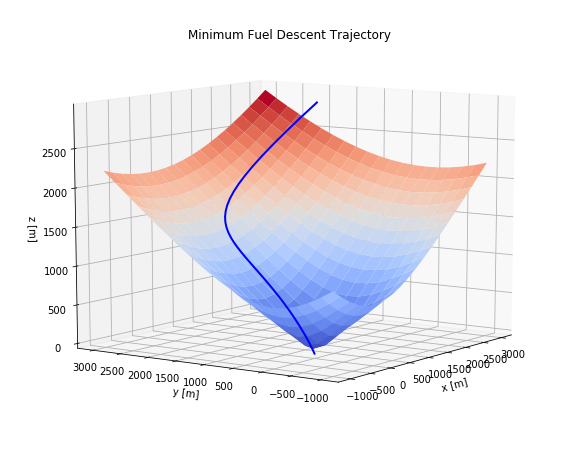

In [4]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')

X = np.linspace(-np.min(p0), np.max(p0), num=20)
Y = np.linspace(-np.min(p0), np.max(p0), num=20)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot(p.value[0,:], p.value[1,:], p.value[2,:], color="blue", linewidth=2)
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]'), ax.set_zlabel('z [m]')
ax.set_title("Minimum Fuel Descent Trajectory")
ax.view_init(10, -145)
plt.show()

The spacecraft reaches its target while obeying all constraints, including remaining within the glide cone.

## Minimum Time Descent

To determine the minimum possible time the spacecraft is capable of reaching the target while obeying all constraints, solve a series of feasibility problems. Start at small $K$ and increase until the problem is feasible.

$$
\begin{equation*}
\begin{aligned}
& \underset{f}{\text{minimize}}
& & 0 \\
& \text{subject to}
& & p^0 =\ p(0),\ p^K = 0 \\
& & & v^0 =\ \dot{p}(0),\ v^K = 0 \\
& & & p^k_3 \geq \alpha \|\ [p^k_1,\ p^k_2]^T]\ \|_2 \\
& & & \|\ f^k\ \|_2 \leq F_{max} \\
& & & v^{k+1} = v^k + \frac{h}{m}f^k - h\vec{g} \\
& & & p^{k+1} = p^k + \frac{h}{2}(v^k + v^{k+1}) \\
& & & \forall\ \ k = 0,\ \ldots,\ K-1
\end{aligned}
\end{equation*}
$$


In [5]:
K_max = K
force_scale = 1e-7
for K in range(1, K_max+1):
    
    # --- Pose Feasibility Problem --- #
    f = cp.Variable((3, K))
    p = cp.Variable((3, K+1))
    v = cp.Variable((3, K+1))

    objective   = cp.Minimize(0)
    constraints = [p[:, 0] == p0,
                   v[:, 0] == v0,
                   p[:, K] == np.asarray([0., 0., 0.]),
                   v[:, K] == np.asarray([0., 0., 0.])]
    constraints += [p[:, i+1] == p[:, i] + (h/2.)*(v[:, i] + v[:, i+1]) for i in range(K)]
    constraints += [v[:, i+1] == v[:, i] + (h/m)*f[:, i] - h*np.asarray([0., 0., g]) for i in range(K)]
    constraints += [force_scale*cp.norm(f[:, i], 2) <= force_scale*Fmax for i in range(K)]
    constraints += [p[2, i] >= alpha*cp.norm(p[0:2, i], 2) for i in range(K)]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    
    if prob.status != "infeasible":
        break

print "\n Minimum Touchdown Time: %2.2f [s]\n" % (K*h)


 Minimum Touchdown Time: 11.00 [s]



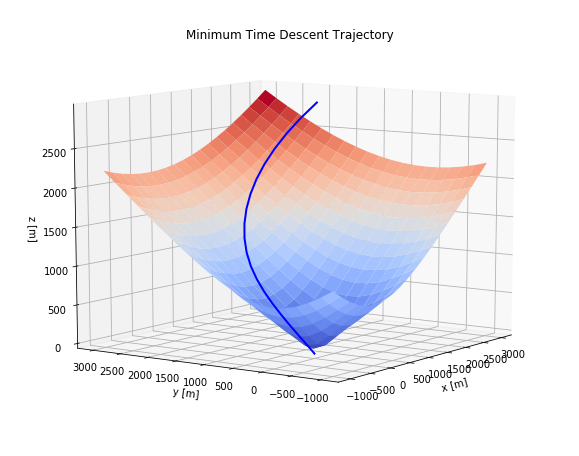

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')

X = np.linspace(-np.min(p0), np.max(p0), num=20)
Y = np.linspace(-np.min(p0), np.max(p0), num=20)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot(p.value[0,:], p.value[1,:], p.value[2,:], color="blue", linewidth=2)
ax.set_xlabel('x [m]'), ax.set_ylabel('y [m]'), ax.set_zlabel('z [m]')
ax.set_title("Minimum Time Descent Trajectory")
ax.view_init(10, -145)
plt.show()

The spacecraft follows a more aggressive trajectory, with thrusters on during the entire duration, unlike in the minimum fuel descent case. 